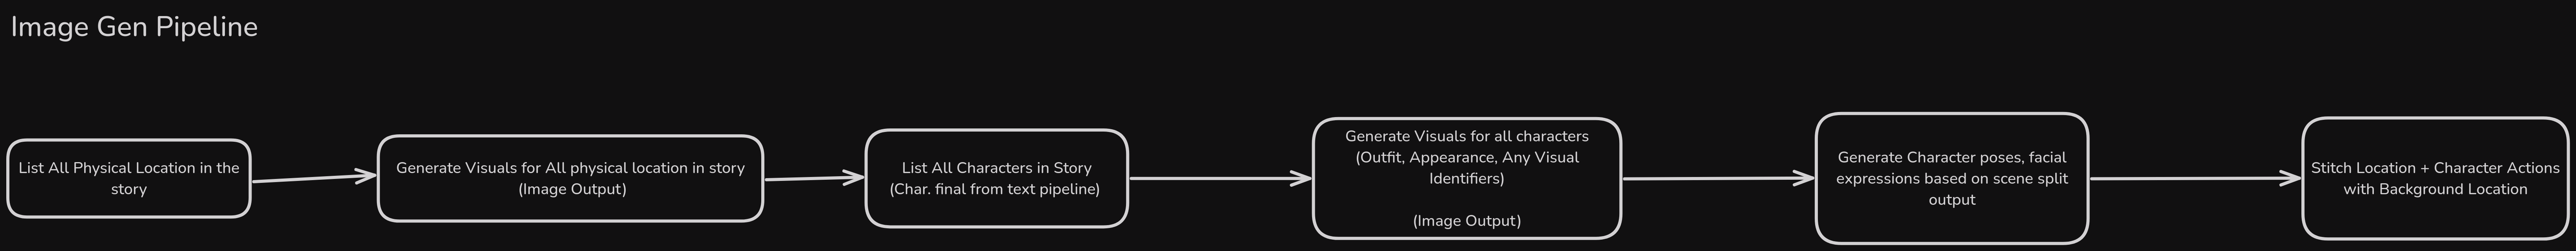

### **Initial Setup**

This notebook utilizes an image generation model. Before you begin, there are a few setup steps you need to complete.

#### **Configure API Secrets**

This notebook requires access to a deployed `gpt-4o` model on Azure.

1.  Click on the **key icon** (Secrets) in the left-hand menu of this Colab notebook.
2.  Create the following three secrets and add your corresponding Azure OpenAI and Replicate credentials:
    *   `AZURE_OPENAI_ENDPOINT`
    *   `AZURE_OPENAI_API_KEY`
    *   `AZURE_OPENAI_API_VERSION`
    *   `REPLICATE_API_TOKEN`
3.  Ensure that you grant this notebook access to these secrets by toggling the "Notebook access" switch for each one.

#### **Grant Google Drive Permissions**

To ensure that your generated images and data are saved persistently, this notebook requires access to your Google Drive.

*   When prompted, please grant full access to your Google Drive.
*   A main folder named `Images` will be created in your Google Drive to store all generated assets. Inside this folder, a new subfolder with a unique timestamp will be created for each run, organizing the generated images into categories such as `Background`, `Character`, and `Scene`.

In [ ]:
# First install required packages
!pip install autogen-agentchat
!pip install autogen
!pip install replicate
!pip install --upgrade numba
!pip install --upgrade pymatting
!pip install --upgrade rembg
!pip install onnxruntime
!pip install ipywidgets
!pip install --upgrade openai

In [ ]:
import base64
import json
import os
import re
from datetime import datetime
from pathlib import Path
from zoneinfo import ZoneInfo
from typing import Annotated

import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests
import replicate
from autogen import AssistantAgent, UserProxyAgent
from google.colab import userdata, drive
from IPython.display import display
from openai import AzureOpenAI, OpenAIError
from openai.types.chat import ChatCompletionMessageParam
from rembg import remove

# environment variables
AZURE_OPENAI_API_KEY = userdata.get("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_API_VERSION = userdata.get("AZURE_OPENAI_API_VERSION")
AZURE_OPENAI_ENDPOINT = userdata.get("AZURE_OPENAI_ENDPOINT")
REPLICATE_API_TOKEN = userdata.get('REPLICATE_API_TOKEN')

# Initialize the clients
azure_openai_client = AzureOpenAI(
            api_key=AZURE_OPENAI_API_KEY,
            azure_endpoint=AZURE_OPENAI_ENDPOINT,
            api_version=AZURE_OPENAI_API_VERSION
            )

replicate_client = replicate.Client(api_token=REPLICATE_API_TOKEN)

image_model = "black-forest-labs/flux-1.1-pro-ultra"

finetuned_flux = "viveksesha/kahani-1:d7e5527f239d3b19216056447ac53688e7dc86d2bd85acdd847399a6ab0d454c"

# Configure LLM
config_list = [
  {
    "model": "gpt-4o-turbo",
    "api_key": AZURE_OPENAI_API_KEY,
    "base_url": AZURE_OPENAI_ENDPOINT,
    "api_type": "azure",
    "api_version": AZURE_OPENAI_API_VERSION,
  },
]
llm_config = {"config_list": config_list}

# Set up timezone for run time
ist = ZoneInfo("Asia/Kolkata")
RUN_TIME = datetime.now(ist).strftime("%d-%m-%Y_%H-%M-%S")


def setup_folder(story_folder_path):
    """Ask the user for a folder name and set up the folder in Google Drive."""
    drive.mount('/content/drive')
    folder_path = f'{story_folder_path}/Images/{RUN_TIME}'
    os.makedirs(folder_path, exist_ok=True)

    backgrounds_path = f"{folder_path}/Backgrounds"
    os.makedirs(backgrounds_path, exist_ok=True)

    characters_path = f"{folder_path}/Characters"
    os.makedirs(characters_path, exist_ok=True)

    scenes_path = f"{folder_path}/Scenes"
    os.makedirs(scenes_path, exist_ok=True)

    print(f"Folder created at: {folder_path}")
    print(f"Backgrounds folder created at: {backgrounds_path}")
    print(f"Characters folder created at: {characters_path}")
    print(f"Scenes folder created at: {scenes_path}")

    return folder_path, backgrounds_path, characters_path, scenes_path


def save_file_to_folder(folder_path: str, file_name: str, generated_image):
    """Save a file with the given content to the specified folder."""
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, 'wb') as f:
        f.write(generated_image)
    print(f"File saved at: {file_path}")


def load_save_files(folder_path: str, file_name: str):
    """ Load saved file in drive"""

    # intial drive location
    drive_location = "/content/drive/My Drive/Kahani/Images"

    # Check if folder exist
    folder_path = f"{drive_location}/{folder_path}"
    if not os.path.exists(folder_path):
        print(f"Folder '{folder_path}' does not exist.")
        return None

    # Check if file exist
    file_path = f"{folder_path}/{file_name}"
    if not os.path.exists(file_path):
        print(f"File '{file_path}' does not exist.")
        return None

    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()

    print(f"File loaded successfully from: {file_path}")
    return content

# Get the output folder from the user
story_folder = input("Enter the folder(with story gen files) of the story gen pipeline: ")

# Setup the folder structure in Google Drive
image_folder_path, backgrounds_folder_path, characters_folder_path, scenes_folder_path = setup_folder(story_folder)

# Test Run
#### Let's check it FLUX can create a Ferrari F1 car race on track

In [ ]:
# Define a prompt for image generation
prompt = """a Lego like Ferrari F1 car race at Spa race track."""

# Run the image generation model with the defined prompt
output = replicate_client.run(image_model, input={"prompt": prompt,
                                            "output_format": "png"})

# Define the path to save the generated image
image_path = os.path.join(image_folder_path, "test.png")

# Save the generated image to the specified path
with open(image_path, "wb") as file:
    file.write(output.read())
    print(f"Image saved at {image_path}")

# Display the generated image
from IPython.display import Image
display(Image(image_path, height=500, width=500))

# **Agents Setup**
Setup agents to generate **prompts** for location, character masters and the Scene Images
##### **NOTE: DO NOT USE AUTO-REPLY WHILE INTERACTING WITH THE AGENTS. THIS MAY CAUSE THE AGENTS TO GO IN A INFINITE LOOP.**

Prefer responding with **'exit'** when done interacting

In [ ]:
# @title Art Style Guidelines

art_style_guidelines = """
# Amar Chitra Katha Art Style Guidelines - Rural Indian Characters

## Character Design Specifications

### Physical Features
- Natural, weathered appearances reflecting outdoor work
- Strong, worked hands with visible calluses
- Sun-weathered skin with varied textures
- More angular and lean body types
- Natural, unstylized postures
- Feet should appear worn and hardened from walking barefoot

### Age Representation
- Include fine lines and wrinkles for older characters
- Weather-beaten features for elderly characters
- Show physical signs of manual labor
- Children should appear naturally slim, not stylized

### Regional Variations
- Skin tones: Rich variety of Indian skin colors (RGB: 215,185,140 to 120,80,60)
- Facial features vary by region:
  - Northern: Sharper, more angular features
  - Southern: Rounder, fuller features
  - Eastern: Softer, rounded eyes
  - Western: More prominent cheekbones

## Clothing Guidelines

### Men's Attire
- Dhoti variations:
  - Simple cotton with minimal pleating
  - Knee-length for working scenes
  - Natural draping without starch
- Shirts/Tops:
  - Half-sleeve shirts with patches
  - Sleeveless banians (vests)
  - Worn cotton gamcha (towel) on shoulder
- Headwear:
  - Regional turbans (pagdi)
  - Simple cotton wraps
  - Weathered Gandhi topi

### Women's Attire
- Sarees:
  - Cotton with simple borders
  - Practical draping for work
  - Worn texture in fabric
  - Regional wrapping styles
- Daily wear:
  - Simple cotton blouses
  - Half-sleeve or sleeveless cuts
  - Practical petticoats
- Working clothes:
  - Hitched sarees for field work
  - Practical draping for movement

### Children's Clothing
- Simple cotton shorts for boys
- Basic frocks or skirts for girls
- Often oversized hand-me-downs
- Minimal clothing for very young children

## Textile Representation

### Fabric Textures
- Coarse cotton weave patterns
- Visible wear and tear
- Natural wrinkles and folds
- Simple patching and mending

### Color Palette
- Earth tones:
  - Raw cotton white (RGB: 230,225,220)
  - Sun-faded indigo (RGB: 60,70,110)
  - Mud brown (RGB: 150,120,90)
  - Dusty ochre (RGB: 180,150,100)
- Aged colors:
  - Weathered blacks
  - Faded primary colors
  - Natural dye shades

## Accessories and Details

### Work Tools
- Detailed farming implements
- Craft tools specific to trade
- Worn wooden handles
- Metalwork with patina

### Personal Items
- Simple thread jewelry
- Glass bangles (women)
- Sacred threads
- Cotton waist strings
- Basic metal toe rings

### Utility Items
- Water containers
- Cloth bundles
- Woven baskets
- Rope bundles

## Environmental Context

### Work Settings
- Agricultural fields
- Village streets
- Local markets
- Craft workshops
- Water sources

### Living Spaces
- Simple mud houses
- Thatched roofs
- Village courtyards
- Community spaces

## Expression Guidelines

### Facial Expressions
- Show dignity in labor
- Natural smiles
- Weather-worn laugh lines
- Focused work expressions
- Genuine emotional depth

### Body Language
- Natural working postures
- Relaxed village gathering poses
- Traditional sitting positions
- Authentic work movements

## Cultural Accuracy

### Regional Markers
- Local ritual elements
- Community customs
- Traditional gestures
- Regional body art

### Social Interactions
- Community gatherings
- Work collaborations
- Family dynamics
- Village hierarchies

## Technical Rendering

### Line Work
- Stronger lines for weathered features
- Texture lines for worn clothing
- Natural flow in fabric folds
- Detailed tool rendering

### Shading
- Sun and shadow effects
- Natural skin variations
- Fabric wear patterns
- Environmental aging

### Detail Priority
- Focus on hands and faces
- Tool handling accuracy
- Fabric draping physics
- Environmental integration

"""

In [ ]:
#@title Character Generation Guidelines
character_generation_guidelines = '''
You are a creative assistant whose task is to generate detailed Flux prompts for character illustration based on given character profiles in JSON format. Your output should instruct an artist or image-generation system to create a full-body illustration in a comic art style. The illustration should highlight the character’s physical appearance, clothing, accessories, jewelry, personality, and expression while ensuring a neutral, natural pose.
Use the art style guidelines.
When processing a character profile, please follow these guidelines and focus points:

1. **Art Style**: [keep the art style the same in all your responses unless otherwise specifies]
    Background: Plain white background of the character with a natural lighting.
    Line Work: Bold outlines with varied weights that harmonize with background contours; maintain subtle, lighter details to echo environmental textures.
    Shading: Soft gradients with clear light-to-dark transitions; incorporate ambient shading that mirrors the scene’s lighting, ensuring characters receive natural, consistent shadows.
    Texture: Suggest material textures in characters that reflect those in the environment, using similar cues to integrate them seamlessly into the scene.
    Color: Earth tones that blend naturally; synchronize character hues with the background palette to ensure a unified, cohesive visual.
    Form: Construct characters with a strong structural foundation that aligns with the overall scene depth, avoiding any isolated or “pasted on” appearance.
    Composition: Position characters so they interact organically with background elements, ensuring balance and a sense of shared space.
    Technical: Utilize varied line pressure and shading techniques that mirror environmental details, enhancing the focal clarity of both characters and the scene.
    Focus: Emphasize essential details on characters that reflect the same light source and atmospheric conditions as the background, reinforcing integration.

2. **Full-Body Illustration:**
   - Clearly state that the illustration must include the entire body (head-to-toe view).
   - Ensure all details of the character’s outfit, accessories, and jewelry are visible.

3. **Physical Appearance:**
   - Extract and detail the character’s key physical traits such as height, build, facial features (e.g., shape, key attributes like nose, eyes, eyebrows, lips), hair type, hair style, hair color, and skin tone.
   - Describe the character’s posture and any distinctive physical features that make them unique.

4. **Clothing and Outfit:**
   - Provide specific details about the character’s attire including outfit type, colors, patterns, textures, and fabric descriptions.
   - Ensure the description covers the complete outfit (upper body, lower body, footwear) with emphasis on cultural or stylistic details if applicable.

5. **Accessories:**
   - List and describe any accessories the character wears (e.g., hats, scarves, bags) and provide details on colors and styles.
   - Give a brief description about the meaning of the accesrory and how it's worn or used.

6. **Jewelry:**
   - If the profile includes jewelry details, describe the types (e.g., rings, necklaces, bracelets), colors, and any symbolic or stylistic significance.

7. **Personality:**
   - Integrate descriptions of the character’s personality from the profile.
   - Convey how their personality should be reflected in their overall appearance and demeanor in the illustration.

8. **Expression:**
   - Describe the facial expression in detail to capture the character’s mood or inner traits (e.g., determined, thoughtful, cheerful).
   - Ensure that the expression aligns with the character’s personality and background.

9. **Neutral Pose:**
   - Instruct that the character should be depicted in a neutral A-pose for maximum visibility.
   - The pose should be natural with straight and relaxed hands and legs, and an overall balanced, natural stance.
   - Avoid overly dramatic or dynamic poses that detract from the detailed presentation of features.

10. **Output Formatting:**
    - Organize the final Flux prompt into clear sections: Introduction, Art Style, Physical Appearance, Clothing and Outfit, Accessories, Jewelry, Personality, Expression, and Pose.
    - Each section should include all necessary details extracted from the character profile to provide a comprehensive guide for the illustration.

**Example of a Detailed Flux Prompt Section:**

Create a **full-body illustration** of [Character Name], a [Age]-year-old [Character Role] using a comic art style with strong line work and vibrant colors. The character should be depicted in a natural, neutral pose with straight, relaxed hands and legs, standing against a plain white background.
**AMAR CHITRA KATHA Art Style**:{the art style should remain constant and unchanged in all your responses}
- Line Work:
    Bold outlines, varied weights. Details use lighter flowing strokes.
- Shading:
    Soft natural gradients with clear light-to-dark transitions.
- Texture:
    Controlled line patterns suggest materials without excessive detail.
- Color:
    Earth tones blend naturally while maintaining material differences.
- Form:
    Natural proportions built from underlying structure, not details.
- Composition:
    Balanced layouts guide eyes through practical element placement.
- Technical:
    Varied line pressure and detail creates clear focal points.
- Focus:
    Essential character shown through selective, meaningful details.

**Physical Appearance**:
[Detail key traits, facial features, hair style and color, skin tone, height, and build.]

**Personality and Expression**:
[Convey the character's personality through facial expression and demeanor, ensuring it is captured authentically.]

**Clothing and Outfit**:
[Detail the complete outfit including upper and lower garments, footwear, and fabric details.]

Accessories:
[List any accessories, with descriptions of their type and color.]

Jewelry:
[Describe any jewelry items, specifying type and design.]


When given a JSON character profile, extract and organize the information according to these guidelines. Your final output should be a cohesive, well-structured Flux prompt that includes all necessary details to generate a full-body illustration that is true to the character's description and artistic requirements.

Character JSON Schema
{{
  "character_number": 0,
  "character_role": "",
  "name": "",
  "age": "",
  "physical_appearance": {{
    "key_traits": "",
    "features": "",
    "personality": "",
    "gender": "",
    "height": "",
    "build": "",
    "hair_style": "",
    "hair_color": "",
    "eye_color": "",
    "skin_tone": "",
    "facial_shape": "",
    "nose": "",
    "lips": "",
    "eyebrows": "",
    "posture": "",
    "movement_style": ""
  }},
  "clothing_and_appearance": {{
    "clothing_color": "",
    "attire_type": "",
    "patterns_and_design": "",
    "texture_and_fabric": "",
    "footwear": ""
  }},
  "jewelry_details": {{
    "jewelry_color": "",
    "jewelry_type": ""
  }},
  "accessory_details": {{
    "accessory_type": "",
    "accessory_color": ""
  }},
  "occupation": "",
  "cultural_background": "",
  "brief_backstory": "",
  "relationship_to_other_characters": "",
  "potential_for_growth_change": ""
}}

'''


In [ ]:
#@title Setup Agents

def _is_termination_message(msg) -> bool:
    """
    Checks if a message indicates the termination of a conversation.

    Args:
        msg (dict): The message dictionary.

    Returns:
        bool: True if the message content ends with 'TERMINATE', False otherwise.
    """

    if isinstance(msg.get("content"), str):
        return msg["content"].rstrip().endswith("TERMINATE")
    elif isinstance(msg.get("content"), list):
        for content in msg["content"]:
            if isinstance(content, dict) and "text" in content:
                return content["text"].rstrip().endswith("TERMINATE")
    return False


# agent that generates character prompts
character_prompt_generator_agent = AssistantAgent(
    name="character_prompt_generator_agent",
    llm_config=llm_config,
    system_message=f"""
                    You are tasked with generating consistent and dynamic images of characters
                    based on structured input provided in JSON format.
                    The character descriptions will include detailed attributes
                    such as name, age, role, cultural background, appearance, occupation, and emotional states.
                    Follow these guidelines carefully to ensure consistency across multiple image generations:

                    {character_generation_guidelines}
                    Here are the art style guidelines you MUST always follow: {art_style_guidelines}
                    You respond with 'TERMINATE' when you have submitted the generated prompt
                    """,
    is_termination_msg=lambda msg: _is_termination_message(msg)
)

# proxy agent that interacts with other agents
human_proxy_agent = UserProxyAgent(
    name="human_proxy_agent",
    human_input_mode="ALWAYS",
    llm_config=llm_config,
    system_message = "You are human proxy who is interacting with the other agents.",
    is_termination_msg=lambda msg: _is_termination_message(msg)
)

print("Agents Setup Successfully!")

# **All the Story Gen files**
Reading all the story gen files

In [ ]:
# Initialize variables to ensure they exist outside the try block
stories = None
character_profiles = None
story_scenes = None

# Load story generation files (stories, character profiles, and scene splitting)
try:
    # Construct full file paths
    stories_path = os.path.join(story_folder, "stories.txt")
    profiles_path = os.path.join(story_folder, "character_profiles.json")
    scenes_path = os.path.join(story_folder, "scene_splitting.json")

    # Open and read the text file
    with open(stories_path, "r") as f:
        stories = f.read()

    # Open and load the character profiles JSON file
    with open(profiles_path, "r") as f:
        character_profiles = json.load(f)

    # Open and load the scene splitting JSON file
    with open(scenes_path, "r") as f:
        story_scenes = json.load(f)

    print("Story generation files loaded successfully.")

except FileNotFoundError as e:
    print(f"Error: The file could not be found - {e}")
    print("Please make sure the 'story_folder' path is correct and the files exist.")
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")
    print("One of the JSON files might be formatted incorrectly.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


# Extract scene settings, only if the files were loaded successfully
if story_scenes:
    settings = []
    # Using .get() is a safer way to access dictionary keys
    for module in story_scenes.get('modules', []):
      for scene in module.get('scenes', []):
        if 'setting' in scene:
          settings.append(scene['setting'])
else:
    print("\nCould not extract scene settings because the files failed to load.")

# **Characters Master Agent**
## Master Visuals
#### Let's generate all the Character Master Images first

##### **Note: Please make sure to generate masters for each of the characters.**

In [ ]:
def get_character_profile(character_id):
    """Get character profile from character_profiles.json"""
    global character_profiles
    try:
        if character_id >= len(character_profiles['character_profiles']):
            raise Exception("Character ID out of range")
            return ""
        else:
            return character_profiles['character_profiles'][character_id]
    except Exception as e:
        print(e)


def generate_character_prompt(character_id: int, feedback: str=""):
    """Initiate conversation with the agent to generate desired prompt"""
    character_profile = get_character_profile(character_id)

    if feedback:
      content = f"""
    Given:
    Current Character Profile: {character_profile}
    Feedback to Implement: {feedback}

    Follow these steps to generate an updated FLUX prompt:

    First, identify ALL changes requested in the feedback
    For each feedback point:

    Note how it modifies the original prompt
    Mark it as mandatory for inclusion
    List any conflicting elements that should be removed.
    Generate a new prompt that:

    Starts with the original character elements
    Incorporates EVERY requested change from the feedback
    Removes any elements that conflict with the feedback
    Maintains prompt clarity and structure
"""
    else:
      content = f"""Here is the character profile: {str(character_profile)}"""

    try:
        chat_results = human_proxy_agent.initiate_chat(
            character_prompt_generator_agent,
            message=content
        )
        prompt = chat_results.chat_history[-1]["content"]
        character_name = character_profile['name']

        if " " in character_name:
            character_name = character_name.replace(" ", "_")

        return character_name, prompt
    except Exception as e:
        print(e)
        return None, None



def generate_character_image(character_name: str, character_prompt: str):
    """Generate image for the character"""
    global characters_folder_path

    IMAGE_GEN_TIME = str(datetime.now(ist).strftime("%d-%m-%Y_%H-%M-%S"))

    output = replicate_client.run(
        finetuned_flux,
        input={
            "prompt": character_prompt,
            "output_format":"png"
        }
    )

    image_name = f"{character_name}_{IMAGE_GEN_TIME}.png"
    # Initialize the image path (note the filetype should be png)
    image_path = os.path.join(characters_folder_path, image_name)

    with open(image_path, "wb") as file:
        file.write(output[0].read())
        print(f"Image saved at {image_path}")

    return image_path

In [ ]:
#@title List Characters
for character_profile in character_profiles['character_profiles']:
    print(character_profile['name'])
    print(json.dumps(character_profile,indent=4), end="\n\n")
    print("-"*100, end="\n\n")

In [ ]:
#@title Character Master Image Generation
#@markdown Type **"exit"** to end conversation with the agent


character_number = 1 #@param {type:"number"}
character_id = character_number-1

character_name, character_prompt = generate_character_prompt(character_id)
character_prompt = character_prompt.strip("TERMINATE")
print(f"Character Name: {character_name}")
print(f"Character Prompt: {character_prompt}")

image_path = generate_character_image(character_name, character_prompt)

# display the image

from IPython.display import Image
display(Image(image_path, width=500, height=500))

In [ ]:
#@title Character Feedback
#@markdown Type **"exit"** to end conversation with the agent

character_feedback = "" #@param {type:"string"}
character_name, character_prompt = generate_character_prompt(character_id, character_feedback)
character_prompt = character_prompt.strip("TERMINATE")
image_path = generate_character_image(character_name, character_prompt)
# display the image
display(Image(image_path, width=500, height=500))

## Select Master Images

Based on the multiple iterations of the master images for the character, please make a final choice to lock in the master images


In [ ]:
#@markdown Run this cell to select master images for each character by clicking the corresponding "Select Image" button below the displayed images.

import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import os
import json
from google.colab import files
import matplotlib.pyplot as plt
import io

# Define character names
character_names = []
for character_profile in character_profiles['character_profiles']:
    character_names.append(character_profile['name'])


class ImageSelector:
    def __init__(self, folder_path, character_list):
        self.folder_path = folder_path
        self.characters = character_list
        self.current_character_index = 0
        self.selected_images = {}

    def get_character_images(self, character_name):
        """Load images specific to the current character"""
        images = []
        image_paths = []

        # Convert character name to the format used in filenames
        character_prefix = character_name.replace(" ", "_")

        for filename in os.listdir(self.folder_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Check if the filename starts with the character's name
                if filename.startswith(character_prefix):
                    img_path = os.path.join(self.folder_path, filename)
                    image_paths.append(img_path)
                    images.append(img_path)

        return images, image_paths

    def display_grid(self):
        """Display character-specific images in a grid and create selection buttons"""
        if self.current_character_index >= len(self.characters):
            print("All characters have been assigned images!")
            self.save_selections()
            return

        current_character = self.characters[self.current_character_index]
        self.images, self.image_paths = self.get_character_images(current_character)

        if not self.images:
            print(f"No images found for {current_character}!")
            self.current_character_index += 1
            self.display_grid()
            return

        clear_output(wait=True)
        print(f"Select a master image for: {current_character}")

        # Calculate grid dimensions
        n_images = len(self.images)
        n_cols = min(5, n_images)  # Maximum 5 images per row
        n_rows = (n_images + n_cols - 1) // n_cols

        # Create figure
        plt.figure(figsize=(15, 3*n_rows))

        # Display images in grid
        for idx, img_path in enumerate(self.images):
            plt.subplot(n_rows, n_cols, idx + 1)

            try:
                img = Image.open(img_path)
                plt.imshow(img)
                plt.axis('off')
                plt.title(f'Image {idx + 1}')
            except Exception as e:
                print(e)
        plt.tight_layout()
        plt.show()

        # Create selection buttons
        buttons = [widgets.Button(description=f'Select Image {i+1}') for i in range(len(self.images))]

        # Define button click handler
        def on_button_click(b):
            idx = int(b.description.split()[-1]) - 1
            self.select_image(self.images[idx])

        # Attach handlers to buttons
        for button in buttons:
            button.on_click(on_button_click)

        # Display buttons in a horizontal box
        button_box = widgets.HBox(buttons)
        display(button_box)

    def select_image(self, image_path):
        """Handle image selection for current character"""
        character = self.characters[self.current_character_index]
        self.selected_images[character] = image_path
        self.current_character_index += 1

        if self.current_character_index < len(self.characters):
            self.display_grid()
        else:
            clear_output(wait=True)
            print("All characters have been assigned images!")
            self.save_selections()

    def save_selections(self):
        """Save selections to JSON file"""
        with open(os.path.join(story_folder, 'character_masters.json'), 'w') as f:
            json.dump(self.selected_images, f, indent=4)
        print(f"\nSelections saved to {os.path.join(story_folder, 'character_masters.json')}")

        # Display final selections
        print("\nFinal Selections:")
        for character, path in self.selected_images.items():
            print(f"{character}: {path}")

        # Display final grid of selected images
        plt.figure(figsize=(15, 3))
        for idx, (character, img_path) in enumerate(self.selected_images.items()):
            plt.subplot(2, 5, idx + 1)
            img = Image.open(img_path)
            plt.imshow(img)
            plt.axis('off')
            plt.title(character, wrap=True)
        plt.tight_layout()
        plt.show()

# Function to run the selector
def run_image_selector(folder_path, character_list):
    selector = ImageSelector(folder_path, character_list)
    selector.display_grid()

# run selector
run_image_selector(characters_folder_path, character_names)

# **Scenes Agent**

In [ ]:
#@title Scene Agent System Guidelines
scene_agent_system_guidelines = '''
You are a creative storytelling assistant specializing in generating detailed flux prompts for visual storytelling. Your task is to create a flux prompt that will guide a visual narrative engine to produce scenes that feature consistent characters and visually coherent settings. The input provided to you will include:

1. **Art Style Guidelines:** A set of rules and aesthetic instructions (e.g., color palettes, artistic influences, visual tone, medium-specific details) that define the overall look and feel of the scene.
2. **Story:** The broader narrative context or plot that informs the scene, including relevant background details.
3. **Scene Description:** A detailed description of the specific scene to be visualized. This should include setting details, mood, lighting, key actions, and any important environmental factors.
4. **Character Profiles:** Comprehensive profiles for each character present in the scene. These profiles should include physical descriptions, personality traits, clothing styles, and any special features or abilities that must remain consistent throughout the narrative.
5. **Character Emotion, Pose, and Action:** Clearly define each character’s emotional state, their physical posture, and what they are actively doing in the scene to enhance storytelling.

### **Your response should adhere to the following guidelines:**
- **Cultural Appropriateness**: Ensure every description has some relation with Indian rural villages. The relative backgrounds, objects in the scene, should reflect what is currenlty avaliable in India and can be seen in the rural India.
- **Integrate All Inputs:** Ensure that the art style guidelines, story context, scene description, and character profiles are seamlessly integrated into a single, coherent flux prompt.
- **Visual Detail:** Provide vivid visual descriptions that capture the mood and aesthetics of the scene. Include specific details that will help ensure that the characters are depicted consistently according to their profiles.
- **Narrative Coherence:** Ensure that the scene description logically fits within the broader story context. The visual narrative should be engaging and faithful to the input provided.
- **Clarity and Precision:** Write in a clear, instructive style that can be directly interpreted by a visual storytelling engine. Avoid ambiguous language.
- **Creative Consistency:** Maintain creative consistency for all characters, ensuring that each character's unique traits and appearances are highlighted and remain consistent across scenes.
- **Expressive Characterization:** Clearly specify **each character’s emotions, their body posture, and what they are doing** in the scene to enhance immersion and storytelling depth.
- **Frequency of objects in the background**: Avoid using words with vagues frequency words such as "few", "many", etc. and mention specific frequency such as two lamps, ten cows, six people.
###**Refine your response:**
- **Generalize the context:** Describe the scene setting as generally as possible while maintaining the integrity of the story and scene. for example, Radha's House can be describe as "a old indian village house".
- **Avoid Specificity:** Avoid using specific words such as human names except when it comes to describing the characters.
- **Easy to Understand:** FLUX uses T5 and CLIP text encodere. Hence your final response should have a prompt that is easier to be understood by FLUX.
- **AVOID TEXT:** Explicitely mention in the prompt to avoid showing any text in the image.

#OUTPUT GUIDELINES: STRICTLY FOLLOW THE OUTPUT FORMAT
### **Output Format:**
1. **Art style description AMAR CHITRA KATHA STYLE:** {keep the art style the same and unchanged in all your responses}
    - Character Elements
        - Line Work: Bold outlines with varied weights that echo background contours.
        - Shading: Soft gradients with transitions matching ambient scene light.
        - Texture: Material cues that mirror environmental textures.
        - Color: Earth tones that blend with the background palette.
        - Form: Structured builds reflecting scene depth, avoiding a pasted-on look.
        - Composition: Organic placement interacting naturally with the scene.
        - Technical: Varied line pressure and shading echoing environmental details.
        - Focus: Key details highlighted by the same light and atmosphere as the background.
    - Background Elements
        - Line Work: Fading, lighter lines that harmonize with character outlines.
        - Shading: Soft, atmospheric shadows matching character lighting.
        - Perspective: Eye-level views with unified depth cues.
        - Texture: Simplified patterns that resonate with character textures.
        - Architecture & Vegetation: Clean, weathered details that interact with characters.
        - Ground Elements: Gradual detail reduction that naturally anchors characters.
        - Color: Muted, desaturated earth tones that harmonize with character hues.
        - Lighting & Atmosphere: A single, consistent light source and subtle value shifts that bind all elements together.
2. **Scene Setting:** [keep the scene setting minimal and simple such that the target is more on the characters themselves and less on the background. Explicitely mention the words "simple" and "minimal"]
    - Visual elements: camera angle
    - Describe the environment, atmosphere, time of the day, etc. details.
    - Use primary and secondary location to build a context of the background and DESCRIBE the background of the image.
    - key_location_elements:
    - cultural_artifacts:
    - NO TEXT IN IMAGE
    - AVOID ANY TEXT IN THE IMAGE
3. **Character Integration:** Describe how each character appears in the scene, referencing their profiles to ensure consistency.
    Total number of characters in scene:

    if there are more than 2 characters in the scene:
            {then only mention each character descriptions[name,age,build,height, hair, skintone, outfit, footwear, accessory type, position in the image] in under 50 words}
    else:
        For each character:
            **Character Profile:**
                Physical appearance: Build, skin tone, hair color,height, facial shape, etc.
                Outfit: Explain character outfit, outfit color[always mention solid colors. for exmaple, "solid red", "solid green"], and footwear
                Accesory: [describe the accessory in under 5 words]
            **Specify the character facial expressions and emotion in detail:**
                Emotion: Describe the character's emotional state (e.g., happy, sad, angry, etc.).
                Overall Posture – Head tilt, neck tension, or relaxed positioning
            **Specific Action and Pose:** Specify the character's body posture, and their actions in the moment in detail [if the character is seated, mention a chair or a bed or on the floor under them. for example "rakha is seated on a simple chair", "Meena is sitting on the floor under the neem tree", "Raju is sitting on a log under a banyan tree"]
            **position in the image:**
4. **Mood and Interaction:** Describe how the scene’s mood influences character dynamics and interactions.
'''

In [ ]:
#@title Scene Image Prompt helper functions
import json
from pydantic import BaseModel

class OverlayPrompt(BaseModel):
    prompt: str

def generate_overlay_prompt(scene: str, characters: str, feedback: str=""):
    """"""
    global scene_agent_system_guidelines
    global stories
    if feedback:
      llm_prompt = f"""Only respond with the overlay prompt without any other information
                Art style guidelines: {art_style_guidelines}
                  Story: {stories[module_id]}
                  Scene: {scene}
                  Characters: {characters}
                  Use the following feedback and make necessary major changes to the prompt.
                  All the changes in the feedback are a top most priority
                  Feedback:
                  {feedback}
                  """
    else:
      llm_prompt = f"""Only respond with the 1000 words overlay prompt and the part of the story the scene is depicting without any other information
                    Art style guidelines: {art_style_guidelines}
                    Story: {stories[module_id]}
                  Scene: {scene}
                  Create detailed deciptions of each character with all the minute details
                  [in your response only depict the characters that are in the list below ignore all other characters in the scene description]
                  Characters: {characters}
                  let's do this step by step
                  always keep the background minimal
                  create the prompt and make sure it passes the NSFW content
                  """

    messages: list[ChatCompletionMessageParam] = [
      {"role": "system", "content": scene_agent_system_guidelines},
      {"role": "user", "content": llm_prompt},
    ]

    response = azure_openai_client.beta.chat.completions.parse(
        model="gpt-4o-turbo",
        messages=messages,
        temperature=1.0,
        response_format=OverlayPrompt,
        max_tokens=4000,
    )
    response = json.loads(response.choices[0].message.content)
    prompt = response["prompt"]

    return prompt

In [ ]:
#@title List Scenes
for module in story_scenes['modules']:
  print(f"Module: {module['module_number']}")
  for scene in module['scenes']:
    print(f"\t- Scene: {scene['scene_number']} -> {scene['title']}")

In [ ]:
#@title **Scene Prompt Generation**
module = 3 #@param {type:"integer"}
scene = 1 #@param{type:"integer"}

module_id = module - 1
scene_id = scene - 1

current_scene = story_scenes['modules'][module_id]['scenes'][scene_id]

character_numbers = []
for character in current_scene['characters_present']:
  character_numbers.append(int(character['character_number']))

characters = []
for character_number in character_numbers:
  characters.append(get_character_profile(character_number-1))


overlay_prompt = generate_overlay_prompt(current_scene, json.dumps(characters))
print(overlay_prompt)



## **Pre-process Master Images**
#### Crop and remove background of each of the character master images to create a more feature rich image for FLUX image prompt

In [ ]:
with open(os.path.join(story_folder, 'character_masters.json'), "r") as file:
    character_masters = json.load(file)
character_masters

In [ ]:
def crop_character_image(image_path, padding=10):
    try:
        # Read the image
        img = cv2.imread(str(image_path))
        if img is None:
            raise ValueError("Failed to load image")

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # Apply Canny edge detection
        # The thresholds can be adjusted based on your specific images
        edges = cv2.Canny(blurred, threshold1=30, threshold2=100)

        # Dilate the edges to connect any gaps
        kernel = np.ones((3,3), np.uint8)
        dilated = cv2.dilate(edges, kernel, iterations=2)

        # Find contours in the edge image
        contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if not contours:
            raise ValueError("No character found in image")

        # Find the largest contour (assuming it's the character)
        largest_contour = max(contours, key=cv2.contourArea)

        # Get the bounding box
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Add padding
        x = max(0, x - padding)
        y = max(0, y - padding)
        w = min(img.shape[1] - x, w + 2 * padding)
        h = min(img.shape[0] - y, h + 2 * padding)

        # Crop the image
        cropped = img[y:y+h, x:x+w]

        return cropped

    except Exception as e:
        print(f"Error processing image: {str(e)}")
        return None

def save_cropped_image(input_path, output_path, padding=10):
    try:
        # Convert paths to Path objects
        input_path = Path(input_path)
        output_path = Path(output_path)

        # Check if input file exists
        if not input_path.exists():
            raise FileNotFoundError(f"Input file not found: {input_path}")

        # Process the image
        cropped = crop_character_image(input_path, padding)
        if cropped is None:
            raise ValueError("Failed to crop image")

        # Save the result
        cv2.imwrite(str(output_path), cropped)
        return True

    except Exception as e:
        print(f"Error saving cropped image: {str(e)}")
        return False

character_cropped_masters = {}
for i in character_masters:
    input_path = character_masters[i]
    output_path = input_path.replace("Characters", "Cropped_Characters")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    if save_cropped_image(input_path, output_path, padding=10):
        character_cropped_masters[i] = output_path
        print(f"Successfully cropped image and saved to {output_path}")
    else:
        print(f"Failed to process image: {input_path}")


In [ ]:
character_cropped_masters

In [ ]:
def remove_background(input_path: str, output_path: str = None):
    image = cv2.imread(input_path)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2RGBA)

    output = remove(image)

    if output_path:
        cv2.imwrite(output_path, output)
        print(f"Saved transparent image at {output_path}")
        return output_path
    else:
        return output_path

rembg_character_masters = {}
for i in character_cropped_masters:
    input_path = character_cropped_masters[i]
    output_path = input_path.replace("Characters", "rembg_Characters")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    rembg_character_masters[i] = remove_background(input_path, output_path)

In [ ]:
rembg_character_masters

## **Character Identification**


In [ ]:
#@title add character system prompt
add_character_system_prompt = """
Your task is to identify the characters in the all the scenes of a story and find which characters do not have a character profile
You will be provided with all the scenes of a story, the story, and the character profiles.
ONLY RESPOND WITH THE FINAL FLUX OUTPUT
Step 1: Check which characters in the scene do not have a character profile
Step 2: Identify the character and generate a character profile for this character.
        Use the following character profile for refereence:
            {{
                "character_number": 1,  # Unique identifier for the character
                "character_role": "string",  # Assign one of the defined character roles, e.g., "Protaganist", "Antagonist"
                "name": "string",  # Reflecting common names in India, e.g., "Rajesh Sharma", "Priya Patel"
                "age": "string",  # Age , e.g., "30", "13" Age should reflect in the relations with other character. for example, a father at a age of 40 can have a daughter of age 20.
                "hometown": "string",  # Place of origin in/near {CITY}, within the state of {STATE}
                "state": "string",  # {STATE} (Keep it {STATE} Unless Specified)
                "ethnicity": "string",  # In relevance to the story and state, considering social and cultural norms.
                "physical_appearance": {{
                    "key_traits": "string",  # Key descriptors, e.g., "strong build, confident"
                    "features": "string",  # Notable physical features, e.g., "sharp nose, deep-set eyes"
                    "personality": "string",  # Personality traits, e.g., "hardworking, resilient"
                    "gender": "string",  # Gender identity, e.g., "male", "female"
                    "height": "string",  # Height or description, e.g., "average", "tall"
                    "build": "string",  # Body type, e.g., "slim", "stocky", "muscular"
                    "hair_type": "string",  # Hair texture, e.g., "thick, wavy", "curly"
                    "hair_style": "string",  # Hairstyle, e.g., "neatly combed", "braided"
                    "hair_color": "string",  # Hair color, e.g., "black", "dark brown"
                    "eye_color": "string",  # Eye color, e.g., "dark brown", "black"
                    "skin_tone": "string",  # Skin tone, e.g., "wheatish", "dusky", "fair"
                    "facial_shape": "string",  # Face shape, e.g., "oval", "round"
                    "nose": "string",  # Nose shape, e.g., "aquiline", "broad"
                    "lips": "string",  # Lip type, e.g., "thin", "full"
                    "eyebrows": "string",  # Eyebrow shape, e.g., "thick", "arched"
                    "posture": "string"  # Posture, e.g., "upright", "relaxed"
                }},
                Description of character outfit that suits the story, reflecting the cultural norms of the story location. The clothing should be appropriate to the age and gender of the character. Specify its color, and type.
                **Keep the outfits simple, practical, and minimalistic. Avoid mentioning an extensive range of colors, intricate embroidery, heavy ornamentation, or luxury textiles.**
                Use clear and concise language to describe garments like sarees, dhotis, lungis, salwar kameez, kurtas, and simple blouses, as well as how they are typically worn. Emphasize the functional aspects of the clothing, such as comfort in hot weather, ease of movement for agricultural work, and cultural significance in daily life.
                "outfit": {{
                    "outfit_color": "string",  # Dominant clothing color only solid colors wihout any patterns, e.g., "black and white", "pink" [IF there are multiple colors, mention which color is for what in the outfit type. for example, black kurta with white pyjama]
                    "outfit_type": "string",  # simple and minimal clothing Type of outfit that suits the story location, reflecting the cultural norms. The attire should be appropriate to the age and gender of the character., e.g., "kurta-dhoti", "salwar-kameez", "shirt and trousers"
                    "texture_and_fabric": "string",  # Fabric type, e.g., "cotton", "khadi"
                    "footwear": "string"  # Footwear type, e.g., "chappals", "mojari", "formal shoes"
                }},
                Add jewelry and its description if it suits with outfit of the character and the context of the story. Add the specific color and type of jewelry.
                Jewelry should be minimal and limited to essential items, such as simple bangles, small earrings, or basic nose studs, as characters from rural India would not have access to or be able to afford elaborate or decorative accessories.
                "jewelry_details": {{
                    "jewelry_type": "string",  # Type of jewelry, e.g.,"small earrings" "bangles", "mangalsutra", "nose ring"
                    "jewelry_color": "string"  # Jewelry color, e.g., "gold", "silver", "brass", "iron"
                    # Not all characters need to wear jewelry; this field can be left empty or set to "N/A".
                }},
                Accessories should be minimal and limited to practical, essential items that support daily life in rural India. Include only items such as a small backpack, a simple sickle, a basic stick, or other functional tools relevant to the local lifestyle. Avoid any decorative, ornamental, or luxury accessories.
                "accessory_details": {{
                    "accessory_type": "string",  # Accessory type, e.g., "gamcha", "pagdi", "dupatta", "backpack", "purse"
                    "accessory_color": "string"  # Accessory color, e.g., "red", "green" simple block colors
                    # Not all characters need accessories; this field can also be left empty or set to "N/A".
                }},
            }}
Step 3: Using this character profile that you just generated create a FLUX prompt which can generate this character on a plain white background.

use the following guidelines to generate the prompt

You are a creative assistant whose task is to generate detailed Flux prompts for character illustration based on given character profiles in JSON format. Your output should instruct an artist or image-generation system to create a full-body illustration in a comic art style. The illustration should highlight the character’s physical appearance, clothing, accessories, jewelry, personality, and expression while ensuring a neutral, natural pose.
Use the art style guidelines.
When processing a character profile, please follow these guidelines and focus points:

1. **Art Style**: [keep the art style the same in all your responses unless otherwise specifies]
    Background: Plain white background of the character with a natural lighting.
    Line Work: Bold outlines with varied weights that harmonize with background contours; maintain subtle, lighter details to echo environmental textures.
    Shading: Soft gradients with clear light-to-dark transitions; incorporate ambient shading that mirrors the scene’s lighting, ensuring characters receive natural, consistent shadows.
    Texture: Suggest material textures in characters that reflect those in the environment, using similar cues to integrate them seamlessly into the scene.
    Color: Earth tones that blend naturally; synchronize character hues with the background palette to ensure a unified, cohesive visual.
    Form: Construct characters with a strong structural foundation that aligns with the overall scene depth, avoiding any isolated or “pasted on” appearance.
    Composition: Position characters so they interact organically with background elements, ensuring balance and a sense of shared space.
    Technical: Utilize varied line pressure and shading techniques that mirror environmental details, enhancing the focal clarity of both characters and the scene.
    Focus: Emphasize essential details on characters that reflect the same light source and atmospheric conditions as the background, reinforcing integration.

2. **Full-Body Illustration:**
   - Clearly state that the illustration must include the entire body (head-to-toe view).
   - Ensure all details of the character’s outfit, accessories, and jewelry are visible.

3. **Physical Appearance:**
   - Extract and detail the character’s key physical traits such as height, build, facial features (e.g., shape, key attributes like nose, eyes, eyebrows, lips), hair type, hair style, hair color, and skin tone.
   - Describe the character’s posture and any distinctive physical features that make them unique.

4. **Clothing and Outfit:**
   - Provide specific details about the character’s attire including outfit type, colors, patterns, textures, and fabric descriptions.
   - Ensure the description covers the complete outfit (upper body, lower body, footwear) with emphasis on cultural or stylistic details if applicable.

5. **Accessories:**
   - List and describe any accessories the character wears (e.g., hats, scarves, bags) and provide details on colors and styles.
   - Give a brief description about the meaning of the accesrory and how it's worn or used.

6. **Jewelry:**
   - If the profile includes jewelry details, describe the types (e.g., rings, necklaces, bracelets), colors, and any symbolic or stylistic significance.

7. **Personality:**
   - Integrate descriptions of the character’s personality from the profile.
   - Convey how their personality should be reflected in their overall appearance and demeanor in the illustration.

8. **Expression:**
   - Describe the facial expression in detail to capture the character’s mood or inner traits (e.g., determined, thoughtful, cheerful).
   - Ensure that the expression aligns with the character’s personality and background.

9. **Neutral Pose:**
   - Instruct that the character should be depicted in a neutral A-pose for maximum visibility.
   - The pose should be natural with straight and relaxed hands and legs, and an overall balanced, natural stance.
   - Avoid overly dramatic or dynamic poses that detract from the detailed presentation of features.

10. **Output Formatting:**
    - Organize the final Flux prompt into clear sections: Introduction, Art Style, Physical Appearance, Clothing and Outfit, Accessories, Jewelry, Personality, Expression, and Pose.
    - Each section should include all necessary details extracted from the character profile to provide a comprehensive guide for the illustration.

**Example of a Detailed Flux Prompt Section:**

Create a **full-body illustration** of [Character Name], a [Age]-year-old [Character Role] using a comic art style with strong line work and vibrant colors. The character should be depicted in a natural, neutral pose with straight, relaxed hands and legs, standing against a plain white background.
**Art Style**:{the art style should remain constant and unchanged in all your responses}
- Line Work:
    Bold outlines, varied weights. Details use lighter flowing strokes.
- Shading:
    Soft natural gradients with clear light-to-dark transitions.
- Texture:
    Controlled line patterns suggest materials without excessive detail.
- Color:
    Earth tones blend naturally while maintaining material differences.
- Form:
    Natural proportions built from underlying structure, not details.
- Composition:
    Balanced layouts guide eyes through practical element placement.
- Technical:
    Varied line pressure and detail creates clear focal points.
- Focus:
    Essential character shown through selective, meaningful details.

**Physical Appearance**:
[Detail key traits, facial features, hair style and color, skin tone, height, and build.]

**Personality and Expression**:
[Convey the character's personality through facial expression and demeanor, ensuring it is captured authentically.]

**Clothing and Outfit**:
[Detail the complete outfit including upper and lower garments, footwear, and fabric details.]

Accessories:
[List any accessories, with descriptions of their type and color.]

Jewelry:
[Describe any jewelry items, specifying type and design.]


When given a JSON character profile, extract and organize the information according to these guidelines. Your final output should be a cohesive, well-structured Flux prompt that includes all necessary details to generate a full-body illustration that is true to the character's description and artistic requirements.

Character JSON Schema
{{
  "character_number": 0,
  "character_role": "",
  "name": "",
  "age": "",
  "physical_appearance": {{
    "key_traits": "",
    "features": "",
    "personality": "",
    "gender": "",
    "height": "",
    "build": "",
    "hair_style": "",
    "hair_color": "",
    "eye_color": "",
    "skin_tone": "",
    "facial_shape": "",
    "nose": "",
    "lips": "",
    "eyebrows": "",
    "posture": "",
    "movement_style": ""
  }},
  "clothing_and_appearance": {{
    "clothing_color": "",
    "attire_type": "",
    "patterns_and_design": "",
    "texture_and_fabric": "",
    "footwear": ""
  }},
  "jewelry_details": {{
    "jewelry_color": "",
    "jewelry_type": ""
  }},
  "accessory_details": {{
    "accessory_type": "",
    "accessory_color": ""
  }},
  "occupation": "",
  "cultural_background": "",
  "brief_backstory": "",
  "relationship_to_other_characters": "",
  "potential_for_growth_change": ""
}}



"""

In [ ]:
#@title generate non essential character
#@markdown if the scene metadata has a extra character who does not have a master image such as a Vegetable Vender. We generate their master image.
from pydantic import BaseModel

class CharResponse(BaseModel):
    character_name: str
    character_profile: str
    flux_prompt: str

def add_character(scene: str):
    """"""
    global characters_folder_path
    global character_profiles

    add_character_user_prompt = f"""
    Characters profiles: {str(character_profiles)}
    Scene: {scene}
"""

    messages: list[ChatCompletionMessageParam] = [
      {"role": "system", "content": add_character_system_prompt},
      {"role": "user", "content": add_character_user_prompt},
    ]

    response = azure_openai_client.beta.chat.completions.parse(
        model="gpt-4o-turbo",
        messages=messages,
        temperature=1.0,
        max_tokens=4000,
        response_format = CharResponse
    )
    if not response.choices:
      print("No response from the model")
      return None

    try:
      response = json.loads(response.choices[0].message.content)
      return response
    except json.JSONDecodeError as e:
      print(f"Error decoding JSON: {e}")
      print(f"Problematic content: {response.choices[0].message.content}")
      return None

def gen_new_character(flux_prompt: str, character_name:str):
    """"""
    global characters_folder_path

    IMAGE_GEN_TIME = str(datetime.now(ist).strftime("%d-%m-%Y_%H-%M-%S"))

    output = replicate_client.run(
        "viveksesha/kahani-1:db69fede8b4e5336171c6678788f66f4ed4aec041e1d717eecf82dc92174858c",
        input={
            "prompt": flux_prompt,
            "output_format": "png",
            "num_inference_steps": 50,
            "guidance_scale": 10,
            "lora_scale": 0.8,
            "model": "dev",
            "diable_safety_checker": True,
        }
    )

    image_name = f"{character_name}_{IMAGE_GEN_TIME}.png"
    # Initialize the image path (note the filetype should be png)
    image_path = os.path.join(characters_folder_path, image_name)

    with open(image_path, "wb") as file:
        file.write(output[0].read())
        print(f"Image saved at {image_path}")

    return image_path


In [ ]:
#@title get characters in scene
characters_in_scene = []
for character in current_scene['characters_present']:
    try:
        if character['name'] in character_cropped_masters:
            print()
            print(f"{character['name']}: {character_cropped_masters[character['name']]}")
            characters_in_scene.append(character['name'])
        else:
            print("No Character Master Image found!! \nGenerating a new one")
            # generate flux prompt
            response = add_character(current_scene)
            flux_prompt = response["flux_prompt"]
            character_name = response["character_name"]
            print(f"\n\n Character name: {character_name}")
            print(f"\nFLUX Prompt: {flux_prompt}\n")

            image_path = gen_new_character(flux_prompt, character_name)



            # display the image
            from IPython.display import Image
            display(Image(image_path, width=500, height=500))

            input_path = image_path
            output_path = input_path.replace("Characters", "Cropped_Characters")
            os.makedirs(os.path.dirname(output_path), exist_ok=True)

            # Simple resizing
            from PIL import Image
            img = Image.open(image_path)
            img = img.resize((img.width // 3, img.height // 3))
            img.save(output_path)

            if save_cropped_image(input_path, output_path, padding=10):
                character_cropped_masters[character_name] = output_path
                print(f"Successfully cropped image and saved to {output_path}")
            else:
                print(f"Failed to process image: {input_path}")

            print(f"Final Master Image path: \n{character_name}: {character_cropped_masters[character_name]}")
            characters_in_scene.append(character_name)
    except:
        print("No Character Master Image found!! \nGenerating a new one")
        # generate flux prompt
        response = add_character(current_scene)
        flux_prompt = response["flux_prompt"]
        character_name = response["character_name"]
        print(f"\n\n Character name: {character_name}")
        print(f"\nFLUX Prompt: {flux_prompt}\n")

        image_path = gen_new_character(flux_prompt, character_name)

        # display the image
        from IPython.display import Image
        display(Image(image_path, width=500, height=500))

        input_path = image_path
        output_path = input_path.replace("Characters", "Cropped_Characters")
        os.makedirs(os.path.dirname(output_path), exist_ok=True)

        # Simple resizing
        from PIL import Image
        img = Image.open(image_path)
        img = img.resize((img.width // 3, img.height // 4))
        img.save(output_path)

        if save_cropped_image(input_path, output_path, padding=10):
            character_cropped_masters[character_name] = output_path
            print(f"Successfully cropped image and saved to {output_path}")
        else:
            print(f"Failed to process image: {input_path}")

        print(f"Final Master Image path: \n{character_name}: {character_cropped_masters[character_name]}")
        characters_in_scene.append(character_name)

In [ ]:
#@title collage of character masters
from PIL import Image
import base64
import io
import math
import os # Import os for path checking

def create_collage(characters_in_scene, character_cropped_masters, columns=None, target_cell_size=(300, 300)):
    """
    Creates a collage of character images in a grid layout.

    Args:
        characters_in_scene (list): A list of character names to include in the collage.
        character_cropped_masters (dict): A dictionary mapping character names
                                         to their corresponding image file paths.
        columns (int, optional): The number of columns in the grid. If None,
                                 it's calculated based on the number of images
                                 (approximately sqrt(n)). Defaults to None.
        target_cell_size (tuple, optional): The target size (width, height) for each
                                           cell in the grid. Images will be scaled
                                           to fit within these dimensions while
                                           maintaining aspect ratio. Defaults to (300, 300).

    Returns:
        str: A base64 encoded data URI string of the generated collage image (PNG format),
             or None if no valid images could be loaded or input is invalid.
    """
    if not characters_in_scene:
        print("NO CHARACTERS IN SCENE!")
        return None

    images = []
    print(f"Attempting to load images for characters: {characters_in_scene}")

    for character in characters_in_scene:
        image_path = character_cropped_masters.get(character)
        if image_path is None:
            print(f"Warning: No image path found for character '{character}'. Skipping.")
            continue

        if not os.path.exists(image_path):
             print(f"Warning: Image file not found at path '{image_path}' for character '{character}'. Skipping.")
             continue

        try:
            img = Image.open(image_path).convert("RGBA") # Convert to RGBA to handle transparency consistently
            images.append(img)
            print(f"Successfully loaded image for '{character}'.")
        except FileNotFoundError:
            print(f"Error: Image file not found at {image_path} for character '{character}'. Skipping.")
        except Exception as e:
            print(f"Error loading image {image_path} for character '{character}': {e}. Skipping.")

    if not images:
        print("No valid images loaded to create collage.")
        return None

    num_images = len(images)

    # Determine grid dimensions
    if columns is None:
        columns = max(1, math.ceil(math.sqrt(num_images))) # Default to a roughly square grid
    else:
        columns = max(1, columns) # Ensure columns is at least 1

    rows = math.ceil(num_images / columns)

    cell_width, cell_height = target_cell_size

    # Calculate collage dimensions
    collage_width = columns * cell_width
    collage_height = rows * cell_height

    # Create the composite image canvas
    # Use RGBA for transparency, initialize with transparent background
    composite = Image.new("RGBA", (collage_width, collage_height), (0, 0, 0, 0))

    scaled_images = []
    # Resize images to fit within cell size while maintaining aspect ratio
    print(f"Scaling {num_images} images to fit within {target_cell_size} cells...")
    for img in images:
        # Calculate scaling factor to fit within target_cell_size
        scale = min(cell_width / img.width, cell_height / img.height)
        new_width = int(img.width * scale)
        new_height = int(img.height * scale)

        # Use a high-quality resampling filter
        scaled_img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
        scaled_images.append(scaled_img)

    # Paste scaled images into the grid
    print("Pasting images into collage grid...")
    for i, img in enumerate(scaled_images):
        row = i // columns
        col = i % columns

        # Calculate position to paste, centering within the cell
        x_offset = col * cell_width + (cell_width - img.width) // 2
        y_offset = row * cell_height + (cell_height - img.height) // 2

        # Ensure paste coordinates are non-negative
        x_offset = max(0, x_offset)
        y_offset = max(0, y_offset)

        try:
            composite.paste(img, (x_offset, y_offset), img) # Use img as mask for transparency
        except Exception as e:
            print(f"Error pasting image {i+1} into collage at ({x_offset}, {y_offset}): {e}")
            # Optionally, skip this image or log more details

    print("Collage created in memory.")

    # Save the collage to a BytesIO object (in memory)
    byte_arr = io.BytesIO()
    try:
        composite.save(byte_arr, format='PNG')
        composite.save(os.path.join(image_folder_path, "collage_test.png"))
        print("Collage saved to memory buffer.")
    except Exception as e:
        print(f"Error saving collage to memory: {e}")
        return None

    # Convert the BytesIO object content to base64 encoded string
    encoded_image_bytes = base64.b64encode(byte_arr.getvalue())
    data_uri = f"data:image/png;base64,{encoded_image_bytes.decode('utf-8')}"

    print("Collage successfully encoded to base64 data URI.")
    return data_uri


image_prompt = create_collage(characters_in_scene, character_cropped_masters, columns=3, target_cell_size=(512, 512))

## Scene Image Generation

In [ ]:
#@title Generate Scene Image
#@markdown image_prompt_strength = 0.79 works the best
IMAGE_GEN_TIME = str(datetime.now(ist).strftime("%d-%m-%Y_%H-%M-%S"))

image_prompt_strength = 0.79 # @param {type:"slider", min:0, max:1, step:0.01}

output = replicate_client.run(image_model, input={"prompt": overlay_prompt,
                                            "image_prompt": image_prompt,
                                            "image_prompt_strength": image_prompt_strength,
                                            "output_format":"png"
                                            }
                            )

image_name = f"{module_id+1}_{scene_id+1}_{IMAGE_GEN_TIME}.png"
# Initialize the image path (note the filetype should be png)
scene_image_path = os.path.join(scenes_folder_path, image_name)

with open(scene_image_path, "wb") as file:
    file.write(output.read())
    print(f"Image saved at {scene_image_path}")

from IPython.display import Image
display(Image(scene_image_path, height=500, width=500))

## Scene Evaluation
**Using GPT-4o as a VLM Judge**


In [ ]:
#@title evaluation system prompt

evaluation_system_guidelines = """
# Image Evaluation System Prompt

You are an expert evaluator agent tasked with analyzing the accuracy and consistency of images in relation to their source material. Your role is to carefully examine scene images, character master images, and associated documentation to ensure high-quality, consistent visual representation.

## Input Materials Analysis

Before beginning your evaluation, confirm you have received all required materials:

1. Scene image showing a specific moment from the story
2. Image with all the character masters in the scene showing full body references
3. The story text providing narrative context
4. Scene description detailing the specific context
5. Art style guidelines defining visual requirements
6. Character profiles with detailed appearance descriptions

## Evaluation Process

### 1. Art Style Evaluation
First, analyze whether the scene image adheres to the provided art style guidelines:

a. Examine the overall artistic technique:
- Does the image follow the specified color palette?
- Are the line weights and drawing style consistent with guidelines?
- Does the shading technique match the required style?
- Is the level of detail appropriate for the established style?

b. Consider stylistic elements:
- Are proportions and anatomical stylization consistent with guidelines?
- Does the perspective handling match style requirements?
- Are textures and patterns rendered according to style specifications?

### 2. Character Consistency Analysis
Compare the characters in the scene image against their master image and profiles:

a. Physical appearance matching:
- Do facial features match between scene and master images?
- Are body proportions consistent?
- Is the character physique the same as described in the character profile?
- Is the character's hair the same as describe in the character profile?
- Is the character's height relative to surroundings accurate?
- Do distinctive features appear correctly?

b. Outfit and accessories:
- Is the character's outfit the same as described in the character profile?
- Are all described accessories present and accurate?
- Are all described accessories depicted accurately?
- Is the clothing behavior (flow, wrinkles, fit) consistent?
- Check if the accesories are out of place.

### 3. Scene Accuracy Assessment
Evaluate if the scene accurately represents the story and scene description:

a. Story context alignment:
- Does the scene match the described moment in the story?
- Are character positions and actions accurate to the narrative?
- Is the emotional tone consistent with the story context?

b. Temporal accuracy:
- Does the scene reflect the correct time of day?
- Are seasonal elements accurately represented?
- Do environmental conditions match the description?

### 4. Background Objects Verification
Analyze all background elements for accuracy and appropriateness:

a. Object presence and placement:
- Are all described objects present in the scene?
- Is the placement logical and consistent with the description?
- Do object sizes maintain proper scale relationships?

b. Object detail accuracy:
- Are objects rendered with appropriate level of detail?
- Do objects match their described characteristics?
- Are there any anachronistic or out-of-place elements?

### 5. Location Consistency Analysis
If this scene occurs in a previously shown location:

a. Spatial consistency:
- Do room layouts match previous depictions?
- Are architectural features consistent?
- Is the scale of the space maintained?

b. Environmental consistency:
- Do permanent fixtures remain in consistent positions?
- Is the lighting direction consistent with previous scenes?
- Are recurring background elements properly maintained?

### 6. Final Contextual Evaluation
Assess the overall effectiveness of the scene's depiction:

a. Narrative support:
- Does the image effectively convey the story moment?
- Are character relationships clearly portrayed?
- Does the mood support the narrative intention?

b. Technical execution:
- Is the composition effective for the scene's purpose?
- Does the lighting enhance the scene's impact?
- Are all elements integrated cohesively?

### 7. Clutter Evaluation
Assess whether the scene is cluttered with unnecessary and extra details:
- Are visual elements well-organized, or do they compete for attention?
- Do any details distract from the main narrative or focal points?
- Is there a clear visual hierarchy guiding the viewer’s eye?
- Could simplifying or removing some elements improve clarity and impact?
- Check for repetition: Are there too many repeated objects that overwhelm or saturate the scene?

### 8. Overall Unexpected and Unrealistic parts
- Check if any elements in the scene are out of place (e.g., a character sitting in mid-air without a chair beneath them).
- Ensure that objects interact naturally with their environment (e.g., shadows align correctly, reflections appear where necessary, and objects cast appropriate occlusions).
- Verify that character proportions, postures, and facial expressions are consistent with real-world physics and anatomy unless intentional stylistic exaggeration is used.
- Look for any floating or disconnected objects that should be anchored to a surface (e.g., books, cups, or furniture appearing to hover without support).
- Assess the consistency of lighting—do shadows and highlights match the intended light source(s)?
- Ensure that clothing, hair, and accessories behave realistically with movement and environmental conditions (e.g., wind affecting fabric, water reflections on wet surfaces).
- Identify any unnatural overlaps or collisions, such as characters' limbs clipping through objects or clothing merging into their bodies.

### 9. Check Text in the image
- Ensure that the image does not contain any text, including watermarks, labels, or unintended markings.
- Verify that no accidental text artifacts are present due to rendering or generation errors.
- Check for any embedded symbols or characters that might resemble text and remove them if unnecessary.
- Ensure that environmental elements like signs, books, or screens do not display readable text unless absolutely required for the scene.
- If the text is absolutely necessary for the scene, then use simple unreadable words and use Indian rupee symbol for all currency

### 10. Miscellaneous
- Ensure that the characters have the same build and physique as described in the character profile
- Is the character emotion correct?
- Is the charcter pose accurate? for e.g. if the scene describes the character sitting, is the character sitting in the correct position in the image?
- Is the number of characters equal to the number of characters shown in the image?
- Are there any duplicate characters in the image?
- Are the characters aligned according to the scene description?

### 11. Character Framing and Integrity
Assess how characters are framed within the scene and check for physical abnormalities:
- Are any characters awkwardly cut off by the edge of the image frame?
- Are entire characters shown, or are significant parts (e.g., half the body) missing without clear artistic or narrative reason? (e.g. like the given image)
- Do any characters appear disproportionately large or small for the scene's perspective?
- Check for incomplete rendering, where parts of a character seem to fade or are not fully drawn.

### 12. Image Composition and Finishing
Evaluate the overall presentation and identify any non-diegetic or unrefined elements:
- Does the image appear as a finished piece, or does it have a sketch-like or incomplete layout?
- Are there distracting or unnecessary white spaces or borders on the sides of the image that are not part of a deliberate framing choice?
- Are there any absurd or out-of-place details that detract from the scene's realism or consistency?
- The evaluation should recommend the removal of such sketch-like layouts and borders to ensure a polished final image.

## Output Format

For each evaluation category, provide:
1. An overall assessment score (1-10)
2. Specific observations supporting your assessment
3. Detailed notes on any inconsistencies found
4. Recommendations for improvements if needed

End your evaluation with a final summary that includes:
1. Overall consistency score
2. Major strengths
3. Critical issues requiring attention
4. Prioritized list of recommended adjustments

Remember to maintain a systematic, objective approach throughout your evaluation, supporting all observations with specific references to the provided materials.

"""

In [ ]:
#@title evaluation user prompt
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

scene_base64_image = encode_image(scene_image_path)
char_master_base64_image = encode_image("collage_test.png")

evaluation_user_prompt = f"""
Scene: {scene}
Story: {stories[module_id]}
character profiles:{json.dumps(characters)}
"""

In [ ]:
#@title Get Evaluation
messages: list[ChatCompletionMessageParam] = [

    {
        "role": "system",
        "content": evaluation_system_guidelines,
    },
    {
        "role": "user",
        "content": [
            {"type": "text",
             "text": evaluation_user_prompt,
            },
            {"type": "image_url",
             "image_url": {"url": f"data:image/jpeg;base64,{scene_base64_image}"},
             "detail": "high"
            },
            {"type": "image_url",
             "image_url": {"url": f"data:image/jpeg;base64,{char_master_base64_image}"},
             "detail": "high"
            },
        ],
    }
]
response = azure_openai_client.beta.chat.completions.parse(
        model="gpt-4o",
        messages=messages,
        temperature=0.95,
        max_tokens=4000,
)
scene_evaluation = response.choices[0].message.content

print(f"Scene Evaluation: \n{scene_evaluation}")

## Refined Scene Image Generation

In [ ]:
#@title final scene agent system prompt
final_scene_system = """
You are an advanced AI assistant specialized in generating and refining Flux model prompts for animated visual storytelling. Your task is to take an input image depicting a storytelling scene and an evaluation of that image, which specifies required modifications. You must generate a detailed and coherent Flux prompt that accurately represents the scene while integrating all necessary changes.


The input provided to you will include:

1. **Art Style Guidelines:** A set of rules and aesthetic instructions (e.g., color palettes, artistic influences, visual tone, medium-specific details) that define the overall look and feel of the scene.
2. **Story:** The broader narrative context or plot that informs the scene, including relevant background details.
3. **Scene Description:** A detailed description of the specific scene to be visualized. This should include setting details, mood, lighting, key actions, and any important environmental factors.
4. **Character Profiles:** Comprehensive profiles for each character present in the scene. These profiles should include physical descriptions, personality traits, clothing styles, and any special features or abilities that must remain consistent throughout the narrative.
5. **Character Emotion, Pose, and Action:** Clearly define each character’s emotional state, their physical posture, and what they are actively doing in the scene to enhance storytelling.
6. **Evaluation: Evaluations of previous prompt through which you will generate a new prompt **
7. **Scene Image: An image in which you have to write a prompt that can make modifications**

Your Process:
Understand the Input Scene:

Analyze the given image, identifying key elements such as characters, setting, actions, and composition.
Extract details like character expressions, attire, background elements, and visual storytelling cues.

Analyze the Evaluation Feedback:

Identify all requested modifications, including character design changes, scene adjustments, lighting corrections, object placement, or thematic improvements.
Ensure that changes align with the storytelling intent and financial literacy theme.

Generate a Comprehensive Flux Prompt:

Construct a new Flux prompt that integrates all changes while maintaining coherence and specificity.
Use precise descriptive language to guide the model in generating an improved version of the image.
Preserve the art style, color scheme, and intended atmosphere while ensuring the modifications enhance clarity and narrative impact.


### **Your response should adhere to the following guidelines:**
- **Cultural Appropriateness**: Ensure every description has some relation with Indian rural villages. The relative backgrounds, objects in the scene, should reflect what is currenlty avaliable in India and can be seen in the rural India.
- **Integrate All Inputs:** Ensure that the art style guidelines, story context, scene description, and character profiles are seamlessly integrated into a single, coherent flux prompt.
- **Visual Detail:** Provide vivid visual descriptions that capture the mood and aesthetics of the scene. Include specific details that will help ensure that the characters are depicted consistently according to their profiles.
- **Narrative Coherence:** Ensure that the scene description logically fits within the broader story context. The visual narrative should be engaging and faithful to the input provided.
- **Clarity and Precision:** Write in a clear, instructive style that can be directly interpreted by a visual storytelling engine. Avoid ambiguous language.
- **Creative Consistency:** Maintain creative consistency for all characters, ensuring that each character's unique traits and appearances are highlighted and remain consistent across scenes.
- **Expressive Characterization:** Clearly specify **each character’s emotions, their body posture, and what they are doing** in the scene to enhance immersion and storytelling depth.
- **Frequency of objects in the background**: Avoid using words with vagues frequency words such as "few", "many", etc. and mention specific frequency such as two lamps, ten cows, six people.

###**Refine your response:**
- **Generalize the context:** Describe the scene setting as generally as possible while maintaining the integrity of the story and scene. for example, Radha's House can be describe as "a old indian village house".
- **Avoid Specificity:** Avoid using specific words such as human names except when it comes to describing the characters.
- **Easy to Understand:** FLUX uses T5 and CLIP text encodere. Hence your final response should have a prompt that is easier to be understood by FLUX.
- **AVOID TEXT:** Explicitely mention in the prompt to avoid showing any text in the image.


### **Output Format:**
1. **Art style description AMAR CHITRA KATHA STYLE:** {keep the art style the same and unchanged in all your responses}
    - Character Elements
        - Line Work: Bold outlines with varied weights that echo background contours.
        - Shading: Soft gradients with transitions matching ambient scene light.
        - Texture: Material cues that mirror environmental textures.
        - Color: Earth tones that blend with the background palette.
        - Form: Structured builds reflecting scene depth, avoiding a pasted-on look.
        - Composition: Organic placement interacting naturally with the scene.
        - Technical: Varied line pressure and shading echoing environmental details.
        - Focus: Key details highlighted by the same light and atmosphere as the background.
    - Background Elements
        - Line Work: Fading, lighter lines that harmonize with character outlines.
        - Shading: Soft, atmospheric shadows matching character lighting.
        - Perspective: Eye-level views with unified depth cues.
        - Texture: Simplified patterns that resonate with character textures.
        - Architecture & Vegetation: Clean, weathered details that interact with characters.
        - Ground Elements: Gradual detail reduction that naturally anchors characters.
        - Color: Muted, desaturated earth tones that harmonize with character hues.
        - Lighting & Atmosphere: A single, consistent light source and subtle value shifts that bind all elements together.
2. **Scene Setting:** [keep the scene setting minimal and simple such that the target is more on the characters themselves and less on the background. Explicitely mention the words "simple" and "minimal"]
    - Visual elements: camera angle
    - Describe the environment, atmosphere, time of the day, etc. details.
    - Use primary and secondary location to build a context of the background and DESCRIBE the background of the image.
    - key_location_elements:
    - cultural_artifacts:
    - NO TEXT IN IMAGE
    - AVOID ANY TEXT IN THE IMAGE
3. **Character Integration:** Describe how each character appears in the scene, referencing their profiles to ensure consistency.
    Total number of characters in scene:

    if there are more than 2 characters in the scene:
            then only mention each character descriptions[name,age,build,height, hair, skintone, outfit, footwear, accessory type, position in the image] in under 50 words
    else:
        For each character:
            4.1  **Character Profile:**
                    Physical appearance: Build, skin tone, hair color,height, facial shape, etc.
                    Outfit: Explain character outfit, outfit color[always mention solid colors. for exmaple, "solid red", "solid green"], and footwear
                    Accesory: [describe the accessory in under 5 words]
                **Specify the character facial expressions and emotion in detail:**
                    Emotion: Describe the character's emotional state (e.g., happy, sad, angry, etc.).
                    Overall Posture – Head tilt, neck tension, or relaxed positioning
                **Specific Action and Pose:** Specify the character's body posture, and their actions in the moment in detail [if the character is seated, mention a chair or a bed or on the floor under them. for example "rakha is seated on a simple chair", "Meena is sitting on the floor under the neem tree", "Raju is sitting on a log under a banyan tree"]
                **position in the image:**
4. **Mood and Interaction:** Describe how the scene’s mood influences character dynamics and interactions.
"""

In [ ]:
#@title Get Final Scene Image prompt

final_scene_prompt = f"""Only respond with the 1000 words overlay prompt and the part of the story the scene is depicting without any other information
                    Art style guidelines: {art_style_guidelines}
                    Story: {stories[module_id]}
                  Scene: {current_scene}
                  Create detailed deciptions of each character with all the minute details
                  Characters: {characters}
                  Use the following evaluation and create a FLUX prompt
                  Evaluation: {scene_evaluation}
                  let's do this step by step
                  """
messages: list[ChatCompletionMessageParam] = [
      {"role": "system", "content": final_scene_system},
      {"role": "user", "content": [
          {"type": "text",
           "text": f"Evaluation: {final_scene_prompt}",
           },
          {"type": "image_url",
             "image_url": {"url": f"data:image/jpeg;base64,{scene_base64_image}"},
             "detail": "high"
            },
          ],
       },
]

response = azure_openai_client.beta.chat.completions.parse(
    model="gpt-4o-turbo",
    messages=messages,
    temperature=1.0,
    max_tokens=4000,
)
final_scene_prompt = response.choices[0].message.content
print(final_scene_prompt)

In [ ]:
from typing_extensions import final
import cv2
import numpy as np

def create_final_collage(image_path1, image_path2, output_path, orientation='horizontal'):
    """
    Create a collage of two images.

    :param image_path1: Path to the first image.
    :param image_path2: Path to the second image.
    :param output_path: Path to save the output collage.
    :param orientation: 'horizontal' or 'vertical' arrangement of images.
    """
    img1 = cv2.imread(image_path1)
    img2 = cv2.imread(image_path2)

    if img1 is None or img2 is None:
        raise ValueError("One or both image paths are invalid.")

    # Resize images to have the same height or width for proper alignment
    if orientation == 'horizontal':
        height = min(img1.shape[0], img2.shape[0])
        img1 = cv2.resize(img1, (int(img1.shape[1] * height / img1.shape[0]), height))
        img2 = cv2.resize(img2, (int(img2.shape[1] * height / img2.shape[0]), height))
        collage = np.hstack((img1, img2))
    else:
        width = min(img1.shape[1], img2.shape[1])
        img1 = cv2.resize(img1, (width, int(img1.shape[0] * width / img1.shape[1])))
        img2 = cv2.resize(img2, (width, int(img2.shape[0] * width / img2.shape[1])))
        collage = np.vstack((img1, img2))

    cv2.imwrite(output_path, collage)
    print(f"Collage saved to {output_path}")

    with open(output_path, "rb") as file:
        data = base64.b64encode(file.read()).decode("utf-8")
        final_scene_image_prompt = f"data:application/octet-stream;base64,{data}"
    return final_scene_image_prompt


In [ ]:
#@title Final Scene Image
#@markdown image_prompt_strength = 0.79 works the best
IMAGE_GEN_TIME = str(datetime.now(ist).strftime("%d-%m-%Y_%H-%M-%S"))

image_prompt_strength = 0.79 # @param {type:"slider", min:0, max:1, step:0.01}

# convert scene image to data uri
with open(scene_image_path, "rb") as file:
    data = base64.b64encode(file.read()).decode("utf-8")
    final_scene_image_prompt = f"data:application/octet-stream;base64,{data}"

# call FLUX API
output = replicate_client.run(image_model, input={"prompt": f"{final_scene_prompt}",
                                            "image_prompt": image_prompt,
                                            "image_prompt_strength": image_prompt_strength,
                                            "output_format":"png"
                                            }
                              )

image_name = f"{module_id+1}_{scene_id+1}_refined_{IMAGE_GEN_TIME}.png"

# Initialize the image path (note the filetype should be png)
final_scene_image_path = os.path.join(scenes_folder_path, image_name)

# save the image
with open(final_scene_image_path, "wb") as file:
    file.write(output.read())
    print(f"Image saved at {final_scene_image_path}")

# display the image
from IPython.display import Image
display(Image(final_scene_image_path, height=500, width=500))

In [ ]:
#@title Image Comparison
import cv2
import matplotlib.pyplot as plt

# Read images
img1 = cv2.imread(scene_image_path)
img2 = cv2.imread(final_scene_image_path)

# Convert BGR to RGB for correct display in Matplotlib
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Display images side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title("Original Scene")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title("Final Scene[After Evaluation]")
plt.axis("off")

plt.show()